# t2i adapter

essentially just took this code and copypastad: https://huggingface.co/docs/diffusers/en/using-diffusers/t2i_adapter

documentation for more control over outputs here: https://huggingface.co/docs/diffusers/v0.31.0/en/api/pipelines/stable_diffusion/adapter#diffusers.StableDiffusionAdapterPipeline

can also play with embedding inputs etc outside of the pipeline.

options for t2i adapters that will take outlines as input:

- TencentARC/t2iadapter_sketch_sd15v2
- TencentARC/t2iadapter_canny_sd15v2

generally, I'd stick with sd 1.4 or 1.5 for ease of deployment (if I get really clever, I think I can deploy these models on CPU, for instance). In this case, I've got SD1.5 loaded.

In [1]:
import cv2
import numpy as np
from PIL import Image
from diffusers.utils import load_image

import torch
from diffusers import StableDiffusionAdapterPipeline, T2IAdapter

/mnt/c/Users/hew7/Documents/venvs/RF-demos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch_device = "cuda" if torch.cuda.is_available() else ("mps" if torch.mps.is_available() else "cpu")

torch_dtype = torch.float16 if torch_device in ["cuda", "mps"] else torch.float32

In [3]:
adapter = T2IAdapter.from_pretrained("TencentARC/t2iadapter_sketch_sd15v2",
                                     torch_dtype=torch_dtype
                                    ).to(torch_device)
pipeline = StableDiffusionAdapterPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    adapter=adapter,
    torch_dtype=torch_dtype,
).to(torch_device)
pipeline.enable_model_cpu_offload()

An error occurred while trying to fetch TencentARC/t2iadapter_sketch_sd15v2: TencentARC/t2iadapter_sketch_sd15v2 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|█████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.81it/s]


In [4]:
input_image = load_image("http://api.getkoala.com/web/companies/qut.edu.au/logo")
input_image = np.array(input_image)

low_threshold = 100
high_threshold = 200

input_image = cv2.Canny(input_image, low_threshold, high_threshold)
input_image = Image.fromarray(input_image)

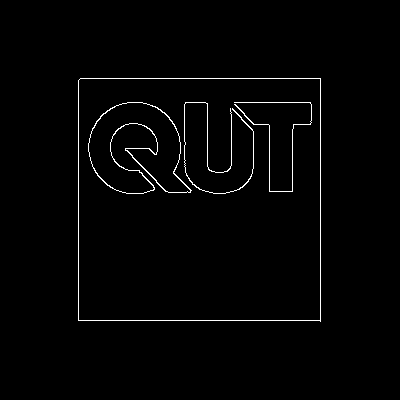

In [5]:
input_image

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.42it/s]
/mnt/c/Users/hew7/Documents/venvs/RF-demos/lib/python3.10/site-packages/diffusers/pipelines/t2i_adapter/pipeline_stable_diffusion_adapter.py:500: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


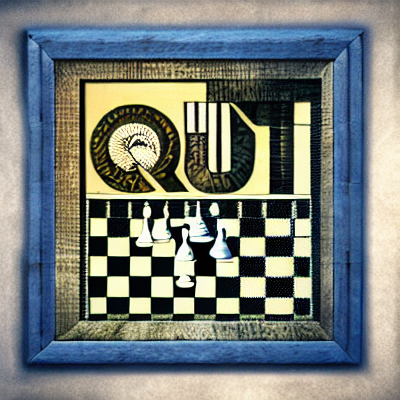

In [6]:
generator = torch.Generator(torch_device).manual_seed(0)

image = pipeline(
    prompt="chess board, van gogh style, muted colours, ",
    image=input_image,
    negative_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality',
    generator=generator,
    num_inference_steps = 100
).images[0]
image